In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline
import numba
from pylab import *

In [13]:
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

In [2]:
L = 250
N = 100
x = np.arange(-int(L/2), int(L/2), 1)
y = np.arange(-int(L/2), int(L/2), 1)
sp = np.meshgrid(x, y)
v = 0.03
lamda=0.03
Fin=0.3/lamda
Tin=3/lamda
delta_theta=np.zeros(N)

##x represents coordinates, v has the components of the velocity (probably superfluous, psi is the orientation, omega is the 
##angular velocity and r is the radius.

particles_x=np.zeros([N,2])
particles_v = np.zeros([N, 2])
particles_psi = np.random.uniform(-np.pi/4, np.pi/4, N)
particles_omega = np.zeros(N)
particles_r = np.zeros(N)

In [5]:
# for i in range (int(np.sqrt(N))):
#     particles_x[10*i:10*(i+1), 0] = np.arange(0, 10)
#     particles_x[10*i:10*(i+1), 1] = i
    
for i in range (int(N/10)):
    particles_x[10*i:(10*(i+1)), 0] = np.arange(0, 1,10) + np.random.uniform(-0.1, 0.1, 10)
    particles_x[int(N*i/10): int(N*(i+1)/10), 1] = np.arange(0, int(N/10), 1) + np.random.uniform(-0.1, 0.1, int(N/10))
    
particles_r[:] = np.random.normal(1, 3/2, N)
particles_v[:, 0] = v*np.cos(particles_psi)
particles_v[:, 1] = v*np.sin(particles_psi)

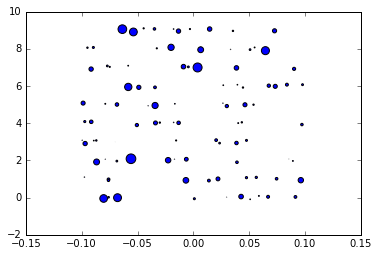

In [6]:

a=np.size(particles_x,0)
plt.scatter(particles_x[:, 0],particles_x[:,1],s=np.pi*(particles_r[:]**2))

In [7]:
def update(N,L,particles_x, particles_r,particles_psi):
    # for me particles_psi is determined by the angles each particle has with the another particles, so the update function just need
    # the position and the radious of each particles
    theta_out = np.zeros(N)
    d_theta = np.zeros(N)
    theta_in=np.zeros(N)
    theta_noise = np.random.random(N)
    v = 0.3
    Fin=0.3
    Tin=3
    particles_omega = (v)/particles_r

    psi_diff = np.zeros([N, N])
    psi_diff = particles_psi[None, :] - particles_psi[:, None]                               
    
    ##distances and angles calculations
    
    # distances between the center of the particles considering its coordinates
    d = np.linalg.norm(particles_x[None, :, :] - particles_x[:, None, :], axis = 2)
    # condition to do not be neighbours
#     d[d > 2.7] = 0
#     d[d<2.7]=1 # condition to be neighbours
    # What I care is about the non-neighbours which do not contribute, so is easy to define
    d[d>2.7]=0
 
    psi_diff = psi_diff * d

    # Orientation between two particles due to the difference between the centers
    particles_dist = particles_x[None, :, :] - particles_x[:, None, :]
    for i in range (N):
        particles_dist[i, i, :] = 100
    
     ##normally, atan return a value between -pi/2 and pi/2. atan2 returns a value between pi and -pi.
        
#     angles = d*np.arctan2(particles_dist[:, :, 1], particles_dist[:, :, 0]) # the angles for non neighbours particles is then bigger than pi
    
# Setting how many particles will be in the boundary
        
    for i in range(N):
        ind=np.where(d[i,:].any()!=0)
        angles=np.zeros(shape=(len(ind),1))
        if len(ind)>3:
            for j in range(len(ind)):
                neigh=np.zeros(shape=(len(ind),2))
                neigh[j,:]=particles_x[ind[j],:]
                angles[j]=arctan2(neigh[j,1],neigh[j,0])
            m=np.amax(angles)-np.amin(angles)
            if abs(m)<np.pi:
                theta_in[i]=(1/2)*m
                theta_out[i] = 2*np.pi - 2*theta_in[i]
                particles_psi=np.pi/2-np.amin(angles)

            
    for i in range (0, N):
            for j in range (0, N):
                d[i, j] -= particles_r[i] + particles_r[j]
    d[d<0] = 0 # when the particles do not overlap
    
    ##distances along different axes
    dx = d*np.cos(particles_psi[:])
    dy = d*np.sin(particles_psi[:])
    
    ##force calculations
#     F_self_x=v*np.cos(particles_psi) # x-direction of the self propulsion force
    
#     F_boundary_x=Fin*np.cos(particles_psi[:])*(theta_out-np.pi)*np.piecewise(theta_out[:] -np.pi, [theta_out[:] -np.pi > 0], [0, 1])# x-direction of the force impose by the boundaries
#     F_repulsion_x=0.1*np.sum(dx,axis=1) # repulsion force due to the overlapping
    
#     F_self_y=v*np.sin(particles_psi)
# #     F_boundary_y=np.tan(angles[:])*F_boundary_x
#     F_boundary_y=Fin*np.sin(particles_psi[:])*(theta_out-np.pi)*np.piecewise(theta_out[:] -np.pi, [theta_out[:] -np.pi > 0], [0, 1])
#     F_repulsion_y=0.1*np.sum(dy,axis=1)
    
#     F_x=F_self_x+F_boundary_x+F_repulsion_x
#     F_y=F_self_y+F_boundary_y+F_repulsion_y
   
    psi_diff = (particles_psi[None, :] - particles_psi[:, None])*d
    
    F = 0.05 + (theta_out[:] - np.pi)*0.3*(theta_out[:]>np.pi) - np.sum(d[:], axis =1)
    F_x = F*np.cos(particles_psi[:])
    F_y = F*np.sin(particles_psi[:])

   
    ## Torque calculations
#     T_noise=np.random.uniform(-1,1, N)
#     T_align=np.sum(psi_diff,1)
#     T = Tin*(d_theta)*np.piecewise(theta_out -np.pi, [theta_out -np.pi > 0], [0, 1]) + T_noise+T_align

    T = 0.06*(theta_out[:]>np.pi) + 0.03*np.random.uniform(-1,1, N) + 0.5*np.sum(psi_diff, axis = 1)[:]
#     #angular velocity and update of the positions
    particles_x[:, 0] = np.mod(particles_x[:, 0] + F_x[:],L)
    particles_x[:, 1] = particles_x[:, 1] + F_y[:]
    particles_psi[:] =particles_psi[:]+T[:]
    
    order_parameter=0
    order_parameter+=particles_psi[:]*1/N
    
 
    return  particles_x,particles_psi

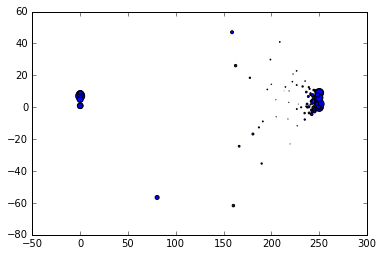

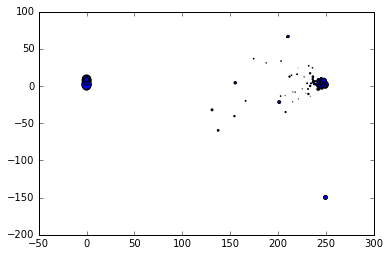

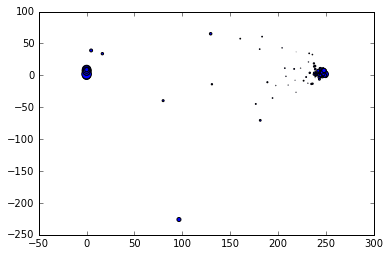

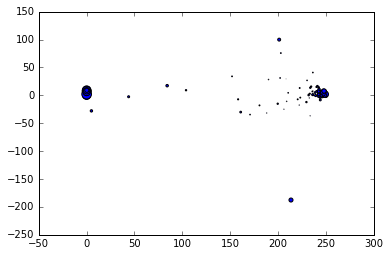

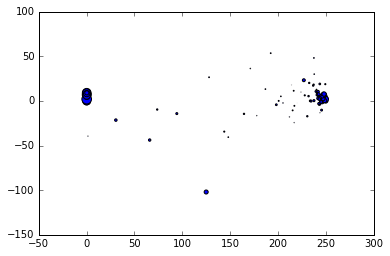

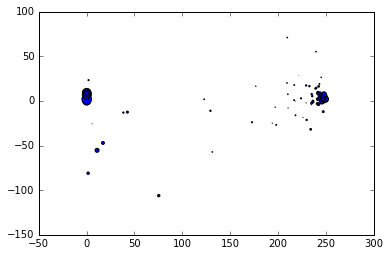

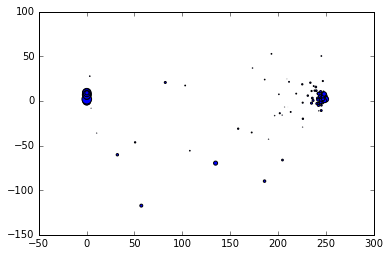

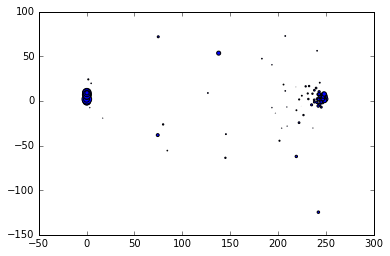

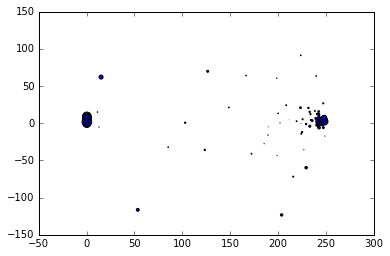

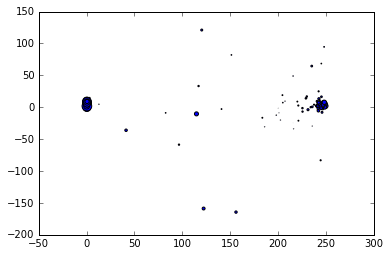

In [8]:
# particles_x[:,0].shape

for i in range(10):
    particles_x,particles_psi=update(N, L, particles_x, particles_r,particles_psi)
#     particle_x=particle.copy()
    plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
    plt.show()
#     print(particles_x)
    
#particles_r.shape
# a=np.zeros([N,N])
# b=(a[None, :] - a[:, None])
# b[1,:].shape
# np.linalg.norm(particles_x[None, :, :] - particles_x[:, None, :], axis = 2).shape

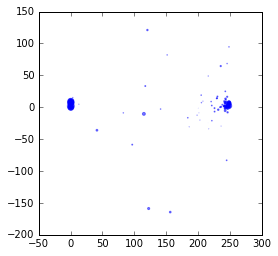

In [18]:
s = np.pi*particles_r[:]**2
figure(figsize=(6,4))
ax = subplot(aspect='equal')

#plot a set of circle
a=particles_x[:, 0]
out = circles(a, particles_x[:, 1], particles_r, alpha=0.5, ec='none')
# colorbar() 
#or colorbar(out)


# plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
# plt.show()

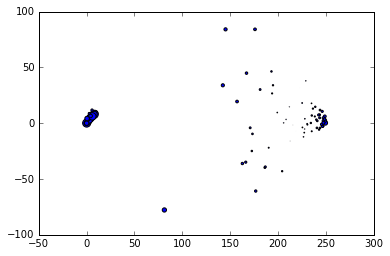

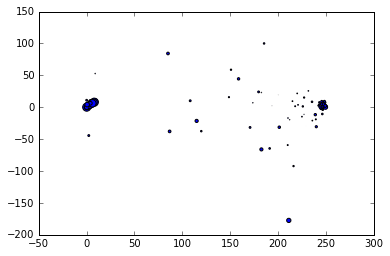

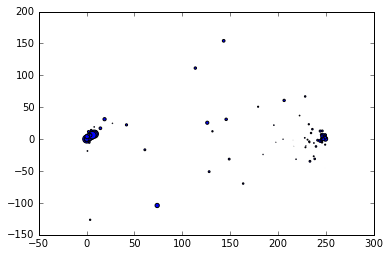

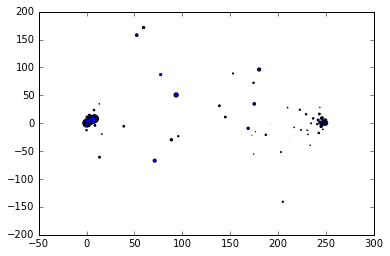

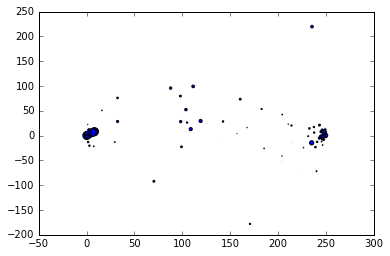

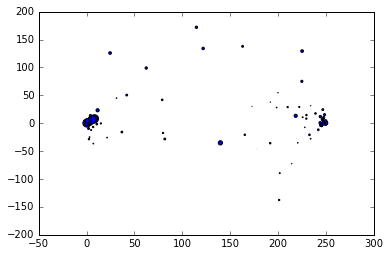

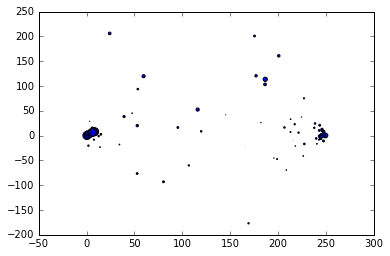

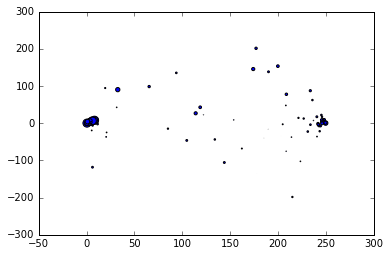

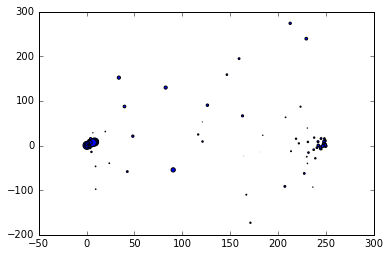

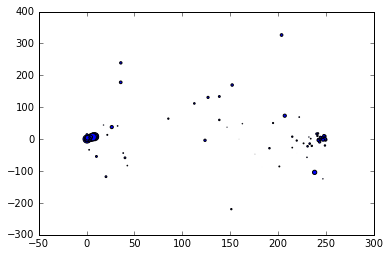

In [161]:
for i in range(10):
    particles_x,particles_psi=update(N, L, particles_x, particles_r,particles_psi)
#     particle_x=particle.copy()
    plt.scatter(particles_x[:, 0], particles_x[:, 1], s = np.pi*particles_r[:]**2)
    plt.show()